In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F

from scipy.stats import gaussian_kde
import ot

In [34]:
kk=1

In [35]:
device = 'cuda:1'

In [36]:
# Define a Convolutional Autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self, embedding_dim=8):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
              nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid(),
        )
        self.embedding_encoder = nn.Sequential(
            nn.Linear(128 * 2 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
            )
        self.embedding_decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * 2 * 2)
            )
        self.embedding_classifier = nn.Sequential(
            nn.Linear(embedding_dim,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,62))

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten        
        embedding = self.embedding_encoder(x)
        logits = self.embedding_classifier(embedding)
        #embedding = embedding/torch.norm(embedding,p=2,dim=-1,keepdim=True)
        xhat = self.decoder(self.embedding_decoder(embedding).view(x.size(0), 128, 2, 2))
        return xhat, embedding,logits

In [37]:
# Define training parameters
batch_size = 512
learning_rate = 1e-4
num_epochs = 50

In [38]:
transform = transforms.Compose([transforms.ToTensor()])

# Load the EMNIST dataset with the 'byclass' split
train_dataset = datasets.EMNIST(root='./data', split='byclass', train=True, transform=transform, download=True)
test_dataset = datasets.EMNIST(root='./data', split='byclass', train=False, transform=transform, download=True)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [39]:
def visualize_data(data_loader, rows=3, cols=5):
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i, (images, labels) in enumerate(data_loader):
        for j in range(rows * cols):
            ax[j // cols, j % cols].imshow(images[j].squeeze(), cmap='gray')
            ax[j // cols, j % cols].set_title(f'Label: {labels[j].item()}')
            ax[j // cols, j % cols].axis('off')
        break  # We only need the first batch
    plt.tight_layout()
    plt.show()


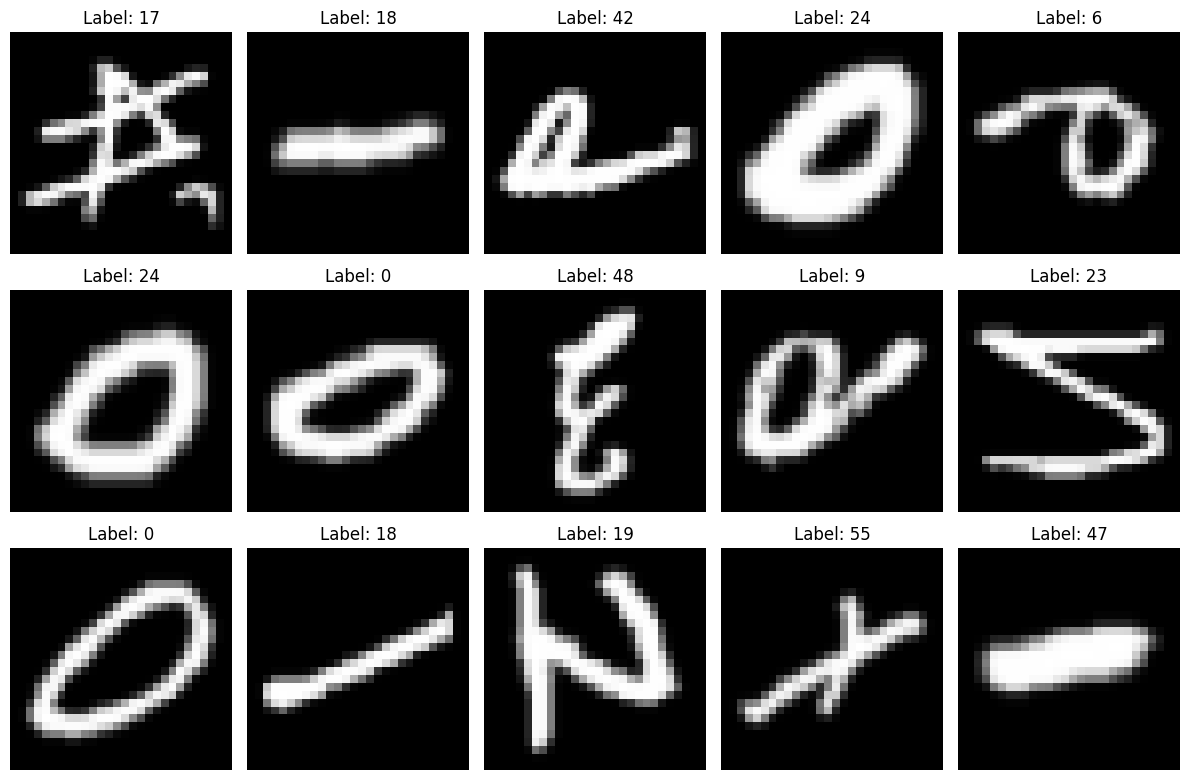

In [40]:
visualize_data(train_loader)

In [41]:
# Initialize the model and optimizer
model = ConvAutoencoder(embedding_dim=6)
model = model.to(device)
criterion1 = nn.BCELoss()
criterion2 = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
# Training loop
train_time_AE = []
train_bce_loss = []
train_mse_loss = []
for epoch in tqdm(range(num_epochs)):
    tic = time.time()
    bce_loss_epoch=0.0
    mse_loss_epoch=0.0
    for data in train_loader:
        images, labels = data
        images,labels = images.to(device), labels.to(device)
        optimizer.zero_grad()        
        outputs, _ ,y_pred = model(images)
        loss1 = criterion1(outputs, images)
        loss2 = criterion2(outputs, images)
        classification_loss = F.cross_entropy(y_pred,labels) 
        loss = loss1 + loss2 + classification_loss
        loss.backward()
        optimizer.step()
        bce_loss_epoch+=loss1.item()
        mse_loss_epoch+=loss2.item()
    toc = time.time()
    train_time_AE.append(toc-tic)
    train_bce_loss.append(bce_loss_epoch/len(train_loader))
    train_mse_loss.append(mse_loss_epoch/len(train_loader))
    print(f'Epoch [{epoch + 1}/{num_epochs}], BCE Loss/epoch: {train_bce_loss[-1]:.4f}, MSE Loss/epoch: {train_mse_loss[-1]:.4f}, Time/epoch: {toc-tic:.4f}')
torch.save(model.state_dict(), './AE_EMNIST_{}.pt'.format(kk))
model.load_state_dict(torch.load('./AE_EMNIST_{}.pt'.format(kk)))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], BCE Loss/epoch: 0.3290, MSE Loss/epoch: 0.0733, Time/epoch: 71.5866
Epoch [2/50], BCE Loss/epoch: 0.2638, MSE Loss/epoch: 0.0498, Time/epoch: 71.3545
Epoch [3/50], BCE Loss/epoch: 0.2469, MSE Loss/epoch: 0.0448, Time/epoch: 70.3926
Epoch [4/50], BCE Loss/epoch: 0.2384, MSE Loss/epoch: 0.0427, Time/epoch: 69.6889
Epoch [5/50], BCE Loss/epoch: 0.2331, MSE Loss/epoch: 0.0413, Time/epoch: 70.5733
Epoch [6/50], BCE Loss/epoch: 0.2295, MSE Loss/epoch: 0.0402, Time/epoch: 72.6971
Epoch [7/50], BCE Loss/epoch: 0.2265, MSE Loss/epoch: 0.0393, Time/epoch: 70.8807
Epoch [8/50], BCE Loss/epoch: 0.2239, MSE Loss/epoch: 0.0385, Time/epoch: 69.5991
Epoch [9/50], BCE Loss/epoch: 0.2216, MSE Loss/epoch: 0.0377, Time/epoch: 70.0151
Epoch [10/50], BCE Loss/epoch: 0.2195, MSE Loss/epoch: 0.0371, Time/epoch: 71.0849
Epoch [11/50], BCE Loss/epoch: 0.2176, MSE Loss/epoch: 0.0364, Time/epoch: 71.3694
Epoch [12/50], BCE Loss/epoch: 0.2158, MSE Loss/epoch: 0.0358, Time/epoch: 69.3972
Epoch [13/50]

<All keys matched successfully>

In [43]:
# train_bce_loss_array = np.array(train_bce_loss)
# np.save('./swae/train_bce_loss_initial25_{}.npy'.format(kk), train_bce_loss_array)
# train_mse_loss_array = np.array(train_mse_loss)
# np.save('./swae/train_mse_loss_initial25_{}.npy'.format(kk), train_mse_loss_array)
# train_time_AE = np.array(train_time_AE)
# np.save('./swae/train_time_initial25_{}.npy'.format(kk), train_time_AE)

In [44]:
# plt.plot(train_mse_loss)
# plt.plot(train_bce_loss)

/home/shahbaa/miniconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


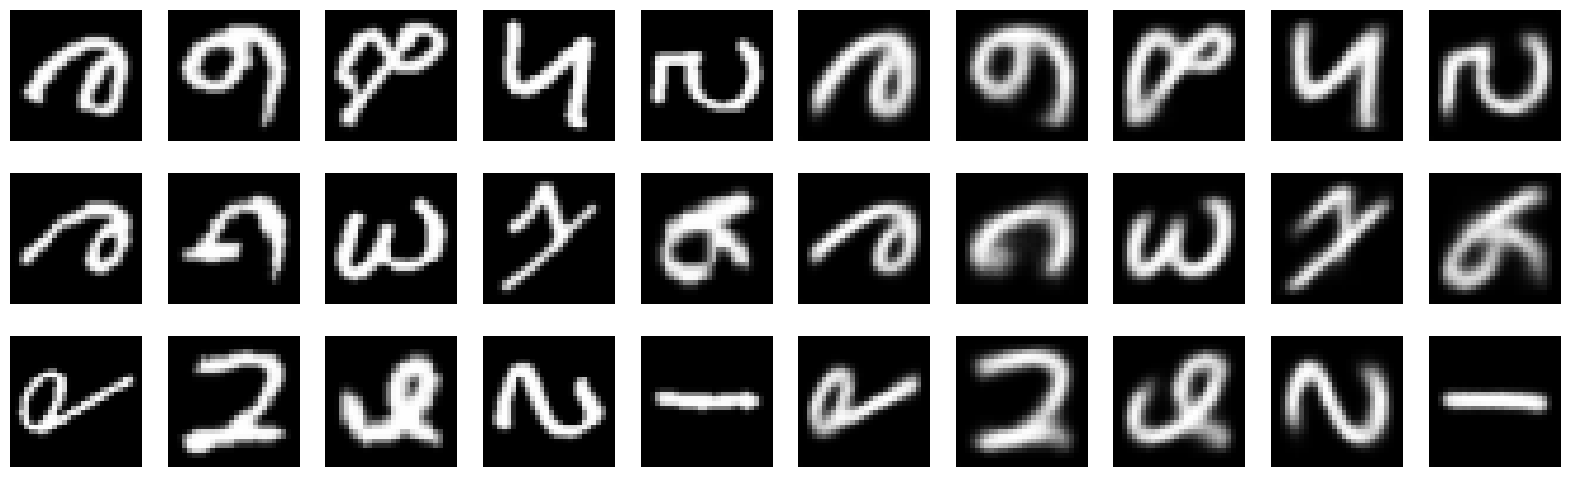

tensor(0.1957) tensor(0.0696)


In [46]:
embeddings = []
labels = []
BCE = []
MSE = []
for data in test_loader:
    images, y = data    
    images = images.to(device)
    outputs, embedding,_ = model(images)
    BCE.append(nn.BCELoss(reduce=False)(outputs,images).mean(dim=[1,2,3]).detach().cpu())
    MSE.append(nn.MSELoss(reduce=False)(outputs,images).mean(dim=[1,2,3]).detach().cpu())
    embeddings.append(embedding.detach().cpu())
    labels.append(y)

embeddings = torch.cat(embeddings)
labels = torch.cat(labels).numpy()
# k = gaussian_kde(embeddings.numpy().T)
# fig, ax = plt.subplots(1, 2, figsize=(20,10), subplot_kw={'projection': "mollweide"})
# scatter_mollweide_ax(embeddings,ax[0],c=labels)
# plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax[1])
# plt.show()

fig, ax = plt.subplots(3, 10, figsize=(20, 6))
for i in range(3):
    for j in range(10):
        if j < 5:  # First half for images
            ax[i, j].imshow(images[i*5+j, ...].squeeze().detach().cpu(), cmap='gray')
        else:  # Second half for outputs
            ax[i, j].imshow(outputs[i*5+j-5, ...].squeeze().detach().cpu(), cmap='gray')
        ax[i, j].axis('off')
plt.show()
BCE = torch.cat(BCE)
MSE = torch.cat(MSE)
print(BCE.mean(),BCE.std())

In [47]:
# test_bce_loss_array = np.array(BCE.numpy())
# np.save('./test_bce_loss_initial25_{}.npy'.format(kk), test_bce_loss_array)
# test_mse_loss_array = np.array(MSE.numpy())
# np.save('./test_mse_loss_initial25_{}.npy'.format(kk), test_mse_loss_array)
# test_embeddings = np.array(embeddings.numpy())
# np.save('./test_embeddings_initial25_{}.npy'.format(kk), test_embeddings)
# test_labels = np.array(labels)
# np.save('./test_labels_initial25_{}.npy'.format(kk), test_labels)

In [32]:
# embedding_dict={'initial':embedding_initial25,'ri1_s3wd':embedding_ri1_s3wd,'s3wd':embedding_S3WD,'sswd':embedding_SSWD}
# w_prior=[]
# for embd in embedding_dict.keys():
#     W=getOT(embedding_dict[embd],prior)
#     print(embd,'=',W)
#     w_prior.append(W)
    